In [502]:
import warnings

warnings.filterwarnings("ignore")

import itertools
import math
import sklearn.datasets as skdata
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import  preprocessing
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use("seaborn-whitegrid")
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

In [503]:
%matplotlib inline

In [1805]:
RCT_DATA = "http://www.nber.org/~rdehejia/data/nsw_dw.dta"
CPS_DATA = "http://www.nber.org/~rdehejia/data/cps_controls3.dta"  # cps調査で直前に無職だったものに限定

df = pd.concat(
    [
        pd.read_stata(RCT_DATA).query("treat>0"),  # (失業者介入実験データ)nsw data の介入群のみ抽出
        pd.read_stata(CPS_DATA),  # 別のセンサスデータ
    ]
).reset_index(drop=True)

del df["data_id"]

df["treat"] = df["treat"].astype(int)
df.sample(10)

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
454,0,16.0,9.0,0.0,0.0,0.0,1.0,411.446014,254.225800,1725.984985
52,1,18.0,11.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
536,0,24.0,12.0,1.0,0.0,0.0,0.0,566.228088,0.000000,2284.564941
469,0,17.0,10.0,0.0,0.0,0.0,1.0,0.000000,152.177399,10301.230469
55,1,17.0,10.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
62,1,35.0,10.0,1.0,0.0,0.0,1.0,0.000000,0.000000,4666.235840
539,0,19.0,9.0,1.0,0.0,0.0,1.0,384.016296,0.000000,0.000000
432,0,39.0,9.0,0.0,0.0,0.0,1.0,11230.519531,537.096802,5752.790039
367,0,17.0,10.0,0.0,0.0,0.0,1.0,568.187378,1525.354980,6231.573242
482,0,47.0,9.0,0.0,0.0,1.0,1.0,25862.320312,0.000000,25564.669922


In [1806]:
features_cols = [col for col in df.columns if col not in ["treat", "re78"]]
features_cols 

['age',
 'education',
 'black',
 'hispanic',
 'married',
 'nodegree',
 're74',
 're75']

In [1808]:
ss = preprocessing.StandardScaler()
df_std = pd.DataFrame(ss.fit_transform(df[features_cols]), columns=features_cols)
df_std = pd.concat([df[["treat", "re78"]], df_std], axis=1)

In [1807]:
df_std .shape

(614, 10)

In [509]:
def ndarray_to_tensor(x):
    x = torch.tensor(x).float()
    return x


class simple_MLP(nn.Module):
    def __init__(self, in_features=1):
        super().__init__()
        self.regression = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        output = self.regression(x)

        return output

In [1809]:
epochs = 10000

model_mlp = simple_MLP(in_features=9)
optimizer = optim.Adam(model_mlp.parameters(), lr=0.01)
criterion = nn.MSELoss()

X_train, X_test, y_train, y_test = train_test_split(
    df_std.drop("re78", axis=1), df_std[["re78"]],
    random_state=0,
    test_size=0.2
)

X_train = ndarray_to_tensor(X_train.to_numpy())
X_test = ndarray_to_tensor(X_test.to_numpy())
y_train = ndarray_to_tensor(y_train.to_numpy())
y_test = ndarray_to_tensor(y_test.to_numpy())

In [1810]:
print("CPUでの処理")
losses = []
start_time = time.time()
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    y_pred = model_mlp(X_train)
    loss = criterion(y_pred, y_train)
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f"epoch:{epoch}, loss:{(losses[-1])**0.5}")
print(f"処理時間：{time.time() - start_time}\n")

CPUでの処理
epoch:1000, loss:6652.150930338246
epoch:2000, loss:5619.146554415537
epoch:3000, loss:5517.163401604125
epoch:4000, loss:6013.584954085209
epoch:5000, loss:5577.326599724997
epoch:6000, loss:5498.388854928324
epoch:7000, loss:4991.691096211784
epoch:8000, loss:4834.778795353516
epoch:9000, loss:4501.836958398205
epoch:10000, loss:4526.1712296376945
処理時間：7.710803031921387



<AxesSubplot:xlabel='true', ylabel='pred'>

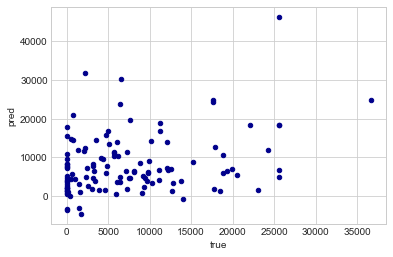

In [1811]:
y_pred = pd.DataFrame(model_mlp(X_test).detach().numpy())
y_pred.columns = ["pred"]
y_pred["true"] = y_test.detach().numpy()
y_pred.plot.scatter(x="true", y="pred", c="DarkBlue")

In [1812]:
# https://github.com/kevinzakka/NALU-pytorch/blob/master/models/mlp.py
class MLP(nn.Module):
    def __init__(
        self,
        num_layers,
        in_dim,
        hidden_dim,
        out_dim,
        activation=nn.ReLU(inplace=True),
        dropout=0.02,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.activation = activation
        self.dropout = dropout

        nonlin = True
        if self.activation is None:
            nonlin = False

        layers = []
        for i in range(num_layers - 1):
            layers.extend(
                self._layer(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim,
                    nonlin,
                )
            )
        layers.extend(self._layer(hidden_dim, out_dim, False))

        self.regression = nn.Sequential(*layers)

        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(m.bias, -bound, bound)

    def _layer(self, in_dim, out_dim, activation=True):
        if activation:
            return [
                nn.Linear(in_dim, out_dim),
                self.activation,
                nn.Dropout(self.dropout),
            ]
        else:
            return [
                nn.Linear(in_dim, out_dim),
            ]

    def forward(self, x):
        out = self.regression(x)
#         out = y_scaler.inverse_transform(out.detach().cpu().numpy())
#         out = torch.tensor(out)
        return  out

In [1813]:
model_mlp = MLP(num_layers=3, in_dim=9, hidden_dim=18, out_dim=1, activation=nn.ReLU(inplace=True), dropout=0.2)

In [1814]:
print("CPUでの処理")
optimizer = optim.Adam(model_mlp.parameters(), lr=0.01)
criterion = nn.MSELoss()
losses = []
start_time = time.time()
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    y_pred = model_mlp(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f"epoch:{epoch}, loss:{(losses[-1])**0.5}")
print(f"処理時間：{time.time() - start_time}\n")

CPUでの処理
epoch:1000, loss:6990.795948960318
epoch:2000, loss:6923.340812064649
epoch:3000, loss:6878.5768876999555
epoch:4000, loss:6836.249556591684
epoch:5000, loss:6843.379866703294
epoch:6000, loss:6865.051784218383
epoch:7000, loss:6761.7116176305535
epoch:8000, loss:6703.756857165988
epoch:9000, loss:6779.267807071793
epoch:10000, loss:6757.441231708937
処理時間：8.424118995666504



<AxesSubplot:xlabel='true', ylabel='pred'>

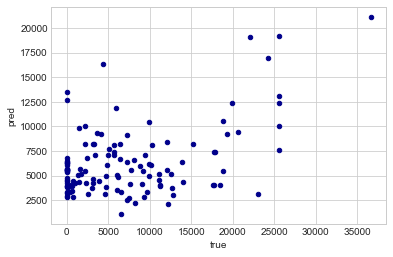

In [1815]:
y_pred = pd.DataFrame(model_mlp(X_test).detach().numpy())
y_pred.columns = ["pred"]
y_pred["true"] = y_test.detach().numpy()
y_pred.plot.scatter(x="true", y="pred", c="DarkBlue")

In [576]:
def error_plot(model, X_train, X_test, y_train, y_test):
    y_pred_train = pd.DataFrame(model_mlp(X_train).detach().numpy())
    y_pred_train.columns = ["pred"]
    y_pred_train["true"] = y_train.detach().numpy()

    y_pred_test = pd.DataFrame(model_mlp(X_test).detach().numpy())
    y_pred_test.columns = ["pred"]
    y_pred_test["true"] = y_test.detach().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    y_pred_train.plot.scatter(x="true", y="pred", ax=ax[0])

    ax[0].plot(
        [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--", lw=1
    )
    ax[0].set_xlabel("measured")
    ax[0].set_ylabel("predicted")
    ax[0].set_title("within sample")

    y_pred_test.plot.scatter(x="true", y="pred", ax=ax[1])

    ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=1)
    ax[1].set_xlabel("measured")
    ax[1].set_ylabel("predicted")
    ax[1].set_title("out of sample")
    plt.show()

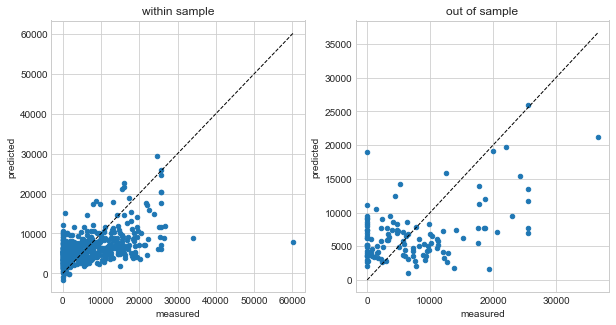

In [577]:
error_plot(model, X_train, X_test, y_train, y_test)

In [1816]:
y_pred.corr()

,pred,true
pred,1.00000,0.48155
true,0.48155,1.00000


In [1817]:
class DataSet:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index, :], self.y[index]
    
train_dataset = DataSet(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataset = DataSet(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True)

max_epoch = 30
criterion = nn.MSELoss()


def objective(trial):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_dim = trial.suggest_int("hidden_dim", 8, 128, 8)
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    learning_rate = trial.suggest_discrete_uniform("learning_rate", 1e-5, 1e-1, q=1e-5)
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)

    net = MLP(
        in_dim=9, hidden_dim=hidden_dim, num_layers=n_layers, out_dim=1, dropout=dropout
    ).to(device)
    
    optimizer = getattr(torch.optim, optimizer)(net.parameters(), lr=learning_rate)

    # train
    net.train()
    for epoch in range(max_epoch):
        for batch in train_dataloader:
            x, t = batch
            x.to(device)
            t.to(device)

            optimizer.zero_grad()
            y = net(x)
            loss = criterion(y, t)
            loss.backward()
            optimizer.step()

    # validation
    net.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            x, t = batch
            x.to(device)
            t.to(device)
            y = net(x)
            loss = criterion(y, t)
            validation_loss += loss.item() * x.size(0)

        validation_loss = validation_loss / len(test_dataloader.dataset)

    return validation_loss

In [1818]:
import optuna
 
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2022-06-09 09:20:47,068] A new study created in memory with name: no-name-4ee63385-8c81-4ccc-8ebd-5b068a0a56df
[W 2022-06-09 09:20:47,420] Trial 0 failed, because the objective function returned nan.
[W 2022-06-09 09:20:47,754] Trial 1 failed, because the objective function returned nan.
[W 2022-06-09 09:20:48,073] Trial 2 failed, because the objective function returned nan.
[W 2022-06-09 09:20:48,371] Trial 3 failed, because the objective function returned nan.
[I 2022-06-09 09:20:48,735] Trial 4 finished with value: 45501892.032520324 and parameters: {'n_layers': 3, 'hidden_dim': 24, 'optimizer': 'Adam', 'learning_rate': 0.01101, 'dropout': 0.11891048779483958}. Best is trial 4 with value: 45501892.032520324.
[I 2022-06-09 09:20:49,205] Trial 5 finished with value: 85235883.38211381 and parameters: {'n_layers': 4, 'hidden_dim': 128, 'optimizer': 'RMSprop', 'learning_rate': 0.08641, 'dropout': 0.33290374287128166}. Best is trial 4 with value: 45501892.032520324.
[I 2022-06-09 09:20

[I 2022-06-09 09:20:59,890] Trial 34 finished with value: 46804640.3902439 and parameters: {'n_layers': 3, 'hidden_dim': 64, 'optimizer': 'Adam', 'learning_rate': 0.0083, 'dropout': 0.13835937846977758}. Best is trial 4 with value: 45501892.032520324.
[I 2022-06-09 09:21:00,263] Trial 35 finished with value: 49880759.3495935 and parameters: {'n_layers': 3, 'hidden_dim': 64, 'optimizer': 'Adam', 'learning_rate': 0.00545, 'dropout': 0.18642751171332572}. Best is trial 4 with value: 45501892.032520324.
[W 2022-06-09 09:21:00,672] Trial 36 failed, because the objective function returned nan.
[W 2022-06-09 09:21:01,106] Trial 37 failed, because the objective function returned nan.
[I 2022-06-09 09:21:01,574] Trial 38 finished with value: 53762675.64227642 and parameters: {'n_layers': 4, 'hidden_dim': 80, 'optimizer': 'Adam', 'learning_rate': 0.01123, 'dropout': 0.41382446497278125}. Best is trial 4 with value: 45501892.032520324.
[W 2022-06-09 09:21:01,890] Trial 39 failed, because the obje

In [1821]:
pred = model_mlp(X_test)
(criterion(pred , y_test))**0.5

tensor(7120.5371, grad_fn=<PowBackward0>)

In [1822]:
study.trials_dataframe().sort_values("value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_learning_rate,params_n_layers,params_optimizer,state
42,42,4.457379e+07,2022-06-09 09:21:02.486403,2022-06-09 09:21:02.850761,0 days 00:00:00.364358,0.145610,48,0.01858,3,Adam,COMPLETE
41,41,4.490935e+07,2022-06-09 09:21:02.201436,2022-06-09 09:21:02.485284,0 days 00:00:00.283848,0.133959,24,0.01933,2,Adam,COMPLETE
44,44,4.537833e+07,2022-06-09 09:21:03.223438,2022-06-09 09:21:03.650101,0 days 00:00:00.426663,0.188709,48,0.00866,4,Adam,COMPLETE
4,4,4.550189e+07,2022-06-09 09:20:48.372671,2022-06-09 09:20:48.735116,0 days 00:00:00.362445,0.118910,24,0.01101,3,Adam,COMPLETE
34,34,4.680464e+07,2022-06-09 09:20:59.517254,2022-06-09 09:20:59.889846,0 days 00:00:00.372592,0.138359,64,0.00830,3,Adam,COMPLETE
28,28,4.739445e+07,2022-06-09 09:20:57.422254,2022-06-09 09:20:57.826810,0 days 00:00:00.404556,0.165433,40,0.02792,2,Adam,COMPLETE
29,29,4.816033e+07,2022-06-09 09:20:57.828184,2022-06-09 09:20:58.110402,0 days 00:00:00.282218,0.137868,16,0.02671,2,Adam,COMPLETE
26,26,4.835705e+07,2022-06-09 09:20:56.733995,2022-06-09 09:20:57.058561,0 days 00:00:00.324566,0.164621,16,0.02631,2,Adam,COMPLETE
19,19,4.836357e+07,2022-06-09 09:20:54.396234,2022-06-09 09:20:54.688564,0 days 00:00:00.292330,0.218743,40,0.06809,2,Adam,COMPLETE
33,33,4.889501e+07,2022-06-09 09:20:59.099577,2022-06-09 09:20:59.516103,0 days 00:00:00.416526,0.256129,40,0.03062,4,Adam,COMPLETE


In [1823]:
study.best_trial.params

{'n_layers': 3,
 'hidden_dim': 48,
 'optimizer': 'Adam',
 'learning_rate': 0.018580000000000003,
 'dropout': 0.145609757628679}

In [1824]:
model_mlp = MLP(
    num_layers=study.best_trial.params["n_layers"],
    in_dim=9,
    hidden_dim=study.best_trial.params["hidden_dim"],
    out_dim=1,
    activation=nn.ReLU(inplace=True),
    dropout=study.best_trial.params["dropout"],
)

print("CPUでの処理")
#optimizer = getattr(torch.optim, optimizer)(model_mlp.parameters(), lr=study.best_trial.params["learning_rate"])
optimizer = optim.RMSprop(model_mlp.parameters(), lr=study.best_trial.params["learning_rate"])
criterion = nn.MSELoss()
losses = []
start_time = time.time()
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    y_pred = model_mlp(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f"epoch:{epoch}, loss:{(losses[-1])**0.5}")
print(f"処理時間：{time.time() - start_time}\n")


CPUでの処理
epoch:1000, loss:7045.56512992393
epoch:2000, loss:6662.045931994165
epoch:3000, loss:6658.615171340059
epoch:4000, loss:6579.51062009934
epoch:5000, loss:6589.6103071426005
epoch:6000, loss:6357.140866773364
epoch:7000, loss:6742.658229511562
epoch:8000, loss:6176.811151395193
epoch:9000, loss:6162.453407531776
epoch:10000, loss:6463.175380569523
処理時間：9.71194076538086



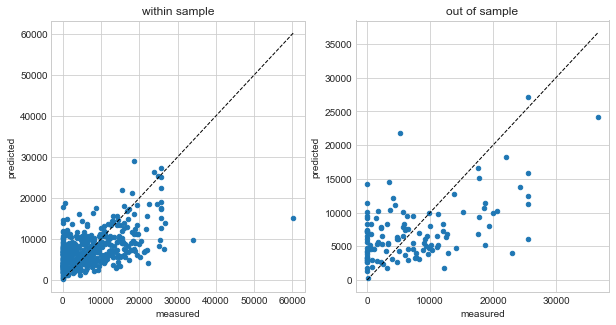

In [1825]:
error_plot(model_mlp, X_train, X_test, y_train, y_test)

In [1826]:
# class MLP(nn.Module):
#     def __init__(self, in_dim=8, out_dim=1):
#         super().__init__()
#         self.regression = nn.Sequential(
#             nn.Linear(in_dim, 20),
#             nn.ReLU(inplace=True),
#             nn.Linear(20, 16),
#             nn.ReLU(inplace=True),
#             nn.Linear(16, 10),
#             nn.ReLU(inplace=True),
#             nn.Linear(10, out_dim),
#         )

#     def forward(self, x):
#         output = self.regression(x)
#         return output


def mmd_rbf(Xt, Xc, p, sig=0.1):
    sig = torch.tensor(sig)
    Kcc = torch.exp(-torch.cdist(Xc, Xc, 2.0001) / torch.sqrt(sig))
    Kct = torch.exp(-torch.cdist(Xc, Xt, 2.0001) / torch.sqrt(sig))
    Ktt = torch.exp(-torch.cdist(Xt, Xt, 2.0001) / torch.sqrt(sig))

    m = Xc.shape[0]
    n = Xt.shape[0]

    mmd = (1 - p) ** 2 / (m * m) * (Kcc.sum() - m)
    mmd += p ** 2 / (n * n) * (Ktt.sum() - n)
    mmd -= -2 * p * (1 - p) / (m * n) * Kct.sum()
    mmd *= 4

    return mmd



# 大幅にかえた
def get_score(model, x_test, y_test, z_test, target_outcome):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    N = len(x_test)
    # combid = [list(x) for x in itertools.combinations(np.arange(z_test.shape[0]), 2)]

    # 新規 MSE
    _ypred = model.forward(x_test, z_test)
    mse = mean_squared_error(y_test, _ypred)

    # treatment index
    t_idx = np.where(t_test.to("cpu").detach().numpy().copy() == 1)[0]

    # ATE & ATT
    _t0 = torch.FloatTensor([0 for _ in range(N)]).reshape([-1, 1])
    _t1 = torch.FloatTensor([1 for _ in range(N)]).reshape([-1, 1])

    _cate = model.forward(x_test, _t1) - model.forward(x_test, _t0)
    _ate = np.mean(_cate.to("cpu").detach().numpy().copy())

    _att = np.mean(_cate[t_idx].to("cpu").detach().numpy().copy())

    for (i, _x) in enumerate(x_test):
        # _y = y_test[i][target_outcome].to_numpy().reshape([-1, 1])
        _y = y_test[i].reshape([-1, 1])
        _z = z_test[i]

        # if model._get_name() in ["TARConv", "TARConvGCN", "CFRConv"]:
        _x = np.tile(_x, [_z.shape[0], 1, 1])
        #         else:
        #             _x = np.tile(_x, [_z.shape[0], 1])
        _x = torch.FloatTensor(_x).to(device=device)
        _z = torch.FloatTensor(_z).to(device=device)
        _z = torch.reshape(_z, (1, 1))
        #         print("before ", _x[0])
        _ypred = model.forward(_x[0], _z)
        if type(_ypred) != np.ndarray:
            _ypred = _ypred.detach().cpu().numpy()

        # ATE, sum outcomes over population
        #         print(_y)
        #         print(combid)
        #         _m_comb = _y[combid]
        #         _ypred_comb = _ypred[combid]

        #         # PEHE, sum personal difference over population
        #         _m_pehe_comb = _m_comb[:, 0] - _m_comb[:, 1]
        #         _ypred_pehe_comb = _ypred_comb[:, 0] - _ypred_comb[:, 1]
        #         _pehe = np.power(_ypred_pehe_comb - _m_pehe_comb, 2)
        if i == 0:
            #             m_comb = _m_comb
            #             ypred_comb = _ypred_comb
            #             pehe = _pehe
            yt = _y
            ypredt = _ypred
        else:
            #             m_comb += _m_comb
            #             ypred_comb += _ypred_comb
            #             pehe += _pehe
            yt = np.r_[yt, _y]
            ypredt = np.r_[ypredt, _ypred]

    #     m_comb = m_comb / N
    #     ypred_comb = ypred_comb / N
    #     pehe = pehe / N
    #     mse = mean_squared_error(yt, ypredt)
    #     diff_abs_ate = np.abs(
    #         (ypred_comb[:, 0] - ypred_comb[:, 1]) - (m_comb[:, 0] - m_comb[:, 1])
    #     )

    #     if type(diff_abs_ate) != np.ndarray:
    #         diff_abs_ate = diff_abs_ate.numpy()
    #         pehe = pehe.numpy()

    #     pm_ate = np.mean(diff_abs_ate)
    #     pm_pehe = np.mean(pehe)
    return {"ATE": _ate, "ATT": _att, "RMSE": np.sqrt(mse)}


class Base(nn.Module):
    def __init__(self, args):
        super(Base, self).__init__()
        self.args = args
        self.criterion = nn.MSELoss()
        self.mse = mean_squared_error

    def check_json(self):
        js = {}
        js.update(vars(self.args))
        for _pop in [
            "din",
            "dtreat",
            "dout",
            "device",
            "disable_cuda",
            "dirpath",
            "log_dir",
        ]:
            try:
                js.pop(_pop)
            except:
                continue

        # 全部同じだったらプログラム終了
        for data in self.js["data"]:
            flag = True
            for _key in js.keys():
                flag *= data[_key] == js[_key]
            if flag == 1:
                sys.exit()

    def save(self):
        # 書き出し
        self.df = pd.DataFrame(self.js["data"]).sort_values(by=["train_rmse"])
        self.df.to_csv(self.filepath)
        with open(self.jfilepath, "w+") as _f:
            json.dump(self.js, _f, indent=4)

    def fit(
        self,
        dataloader,
        x_train,
        M_train,
        Z_train,
        x_test,
        M_test,
        Z_test,
        target_outcome,
        logger,
    ):
        losses = []
        logger.debug("                        within sample,      out of sample")
        logger.debug("           [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]")
        for epoch in range(3000):
            epoch_loss = 0
            n = 0
            for (x, y, z) in dataloader:
                if self.args["alpha"] > 0.0:
                    zuniq, zcount = np.unique(
                        z.cpu().detach().numpy(), axis=0, return_counts=True
                    )

                x = x.to(device=torch.device("cpu"))
                y = y.to(device=torch.device("cpu"))
                z = z.to(device=torch.device("cpu"))
                self.optimizer.zero_grad()
                #                 _, x_rep_stack = self.repnet(x)
                #                 x_rep = x_rep_stack[2]
                x_rep = self.repnet(x)
                y_hat = self.outnet(torch.cat((x_rep, z), 1))
                loss = self.criterion(y_hat, y.reshape([-1, 1]))

                if self.args["alpha"] > 0.0:
                    # zi = zuniq[np.random.permutation(np.arange(len(zcount)))[0]]
                    zi = zuniq[zcount.argmax()]
                    i_id = np.where((z.cpu().detach().numpy() == zi).all(axis=1))[0]
                    zjs = zuniq.tolist()
                    zjs.pop(zcount.argmax())
                    zjs = np.array(zjs)
                    ipm = 0
                    for (i, (zj)) in enumerate(zjs):
                        j_id = np.where((z.cpu().detach().numpy() == zj).all(axis=1))[0]
                        # ipm += mmd_lin(x_rep_stack[2][i_id], x_rep_stack[2][j_id], p=len(i_id)/(len(i_id)+len(j_id)))
                        ipm += mmd_rbf(
                            x_rep[i_id],
                            x_rep[j_id],
                            p=len(i_id) / (len(i_id) + len(j_id)),
                            sig=self.args["sig"],
                        )
                    loss += ipm * self.args["alpha"]

                #                 mse = self.mse(
                #                     self.y_scaler.inverse_transform(y_hat.detach().cpu().numpy()),
                #                     self.y_scaler.inverse_transform(
                #                         y.reshape([-1, 1]).detach().cpu().numpy()
                #                     ),
                #                 )
                mse = self.mse(
                    y_hat.detach().cpu().numpy(),
                    y.reshape([-1, 1]).detach().cpu().numpy(),
                )
                loss.backward()

                self.optimizer.step()
                epoch_loss += mse * y.shape[0]
                n += y.shape[0]

            self.scheduler.step()
            epoch_loss = epoch_loss / n
            losses.append(epoch_loss)

            if epoch % 100 == 0:
                with torch.no_grad():
                    # ATE, sqrt(pehe), cmse
                    within_pm = get_score(
                        self, x_train, M_train, Z_train, target_outcome
                    )
                    outof_pm = get_score(self, x_test, M_test, Z_test, target_outcome)
                logger.debug(
                    "[Epoch: %d] [%.3f], [%.3f, %.3f, %.3f], [%.3f, %.3f, %.3f] "
                    % (
                        epoch,
                        epoch_loss,
                        within_pm["RMSE"],
                        within_pm["ATT"],
                        within_pm["ATE"],
                        outof_pm["RMSE"],
                        outof_pm["ATT"],
                        outof_pm["ATE"],
                    )
                )

        return within_pm, outof_pm, losses


class CFR(Base):
    def __init__(self, dtreat, y_scaler, args={}):
        super().__init__(args)
        #         self.repnet = MLP(in_dim=8, out_dim=3)
        self.repnet = MLP(
            num_layers=3,
            in_dim=8,
            hidden_dim=100,
            out_dim=100,
            activation=nn.ReLU(inplace=True),
            dropout=0.95
        )
        self.outnet = MLP(
            in_dim=100 + dtreat, out_dim=1, num_layers=3, hidden_dim=200, dropout=0.5
        )
        self.params = list(self.repnet.parameters()) + list(self.outnet.parameters())
        self.optimizer = optim.Adam(
            params=self.params, lr=args["lr"], weight_decay=args["wd"]
        )
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.97)
        self.y_scaler = y_scaler

    def forward(self, x, z):
        with torch.no_grad():
            #             _, x_rep_stack = self.repnet(x)
            #             x_rep = x_rep_stack[2]
            x_rep = self.repnet(x)
            #             print("forward", z)
            #             print("forward", x_rep)
            #             print("forward", torch.cat([x_rep, z], 1))
            y_hat = self.outnet(torch.cat((x_rep, z), 1))
        #             y_hat = self.y_scaler.inverse_transform(y_hat.detach().cpu().numpy())

        return y_hat

In [1827]:
class DataSet:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index, :], self.y[index], self.z[index, :]

In [1828]:
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    df.drop(["re78", "treat"], axis=1),
    df[["re78"]],
    df[["treat"]],
    random_state=0,
    test_size=0.1,
)


X_train = torch.FloatTensor(X_train.to_numpy())
y_train = torch.FloatTensor(y_train.to_numpy())
t_train = torch.FloatTensor(t_train.to_numpy())
dataset = DataSet(X_train, y_train, t_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)


X_test = torch.FloatTensor(X_test.to_numpy())
y_test = torch.FloatTensor(y_test.to_numpy())
t_test = torch.FloatTensor(t_test.to_numpy())

In [1829]:
# test

for (x, y, z) in dataloader:

    zuniq, zcount = np.unique(z.cpu().detach().numpy(), axis=0, return_counts=True)

In [1830]:
model

CFR(
  (criterion): MSELoss()
  (repnet): MLP(
    (activation): ReLU(inplace=True)
    (regression): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.05, inplace=False)
      (3): Linear(in_features=8, out_features=8, bias=True)
    )
  )
  (outnet_treated): MLP(
    (activation): ReLU(inplace=True)
    (regression): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.05, inplace=False)
      (3): Linear(in_features=8, out_features=1, bias=True)
    )
  )
  (outnet_control): MLP(
    (activation): ReLU(inplace=True)
    (regression): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.05, inplace=False)
      (3): Linear(in_features=8, out_features=1, bias=True)
    )
  )
)

In [1831]:
din = X_train.shape[1]
dtreat = t_train.shape[1]
model = CFR(dtreat, y_scaler, args={"lr": 1e-3, "wd": 0.5, "alpha": 0.5, "sig": 0.1})

In [1832]:
from logging import getLogger, StreamHandler, FileHandler, Formatter, DEBUG
class Logger(object):
    def __init__(self, fname):
        self.terminal = sys.stdout
        self.log = open(fname, "w")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def close(self):
        self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


In [1833]:
from datetime import datetime
logger = getLogger("run DFR")
logger.setLevel(DEBUG)
handler_format = Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler = StreamHandler()
stream_handler.setLevel(DEBUG)
stream_handler.setFormatter(handler_format)
file_handler = FileHandler(
    "logs/"
    + "cfr"
    + "-"
    + "{:%Y-%m-%d-%H:%M:%S}.log".format(datetime.now()),
    "a",
)
file_handler.setLevel(DEBUG)
file_handler.setFormatter(handler_format)
logger.addHandler(stream_handler)
logger.addHandler(file_handler)
logger.debug("Start process.")

2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start process.
2022-06-09 09:22:54,889 - run DFR - DEBUG - Start proces

In [1834]:
within_pm, outof_pm, train_mse = model.fit(
    dataloader, X_train, y_train, t_train, X_test, y_test, t_test, "", logger
)

2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,

2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,      out of sample
2022-06-09 09:22:56,389 - run DFR - DEBUG -                         within sample,

2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE

2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 09:22:56,534 - run DFR - DEBUG -            [Train MSE], [RMSE

2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134

2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134.580, -299.924, 98.586], [8905.784, 194.810, -301.096] 
2022-06-09 09:22:57,185 - run DFR - DEBUG - [Epoch: 0] [87798022.913], [9134

2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100

2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100] [75190284.435], [8739.798, 673.757, 187.553], [8327.174, 841.329, -1059.925] 
2022-06-09 09:23:11,320 - run DFR - DEBUG - [Epoch: 100

2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epo

2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epoch: 200] [73728036.812], [8719.830, -710.863, 33.936], [9551.929, -201.884, -1514.405] 
2022-06-09 09:23:25,078 - run DFR - DEBUG - [Epo

2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [7596

2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [75963809.927], [8644.954, 1513.185, 202.574], [8603.736, 112.590, 809.345] 
2022-06-09 09:23:38,208 - run DFR - DEBUG - [Epoch: 300] [7596

2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [86

2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [8634.321, -41.782, 116.536], [9073.739, 383.690, 71.660] 
2022-06-09 09:23:51,325 - run DFR - DEBUG - [Epoch: 400] [82714933.714], [86

2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [6829

2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [68291061.464], [8721.438, 355.759, 51.628], [8004.917, -309.172, -762.131] 
2022-06-09 09:24:05,553 - run DFR - DEBUG - [Epoch: 500] [6829

2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [7148

2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [71480641.870], [8323.458, -562.790, 58.341], [7859.508, 297.202, -484.992] 
2022-06-09 09:24:19,902 - run DFR - DEBUG - [Epoch: 600] [7148

2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.24

2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.246], [8504.839, 577.000, 188.635], [9181.464, 359.745, 306.853] 
2022-06-09 09:24:32,914 - run DFR - DEBUG - [Epoch: 700] [65943340.24

2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.89

2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.899], [8044.305, -385.288, 241.435], [8788.638, 3.111, -373.330] 
2022-06-09 09:24:45,901 - run DFR - DEBUG - [Epoch: 800] [68418203.89

2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [6483

2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [64833151.293], [8276.271, 389.902, 381.952], [8598.254, -1876.542, 50.897] 
2022-06-09 09:24:58,894 - run DFR - DEBUG - [Epoch: 900] [6483

2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.4

2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.420], [8164.951, 902.411, 40.678], [8052.200, -895.340, 42.185] 
2022-06-09 09:25:11,861 - run DFR - DEBUG - [Epoch: 1000] [67957077.4

2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG

2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG

2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:24,811 - run DFR - DEBUG - [Epoch: 1100] [68849422.717], [8136.305, 939.195, -212.091], [7887.688, -1240.294, 520.991] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DF

2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,

2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,755 - run DFR - DEBUG - [Epoch: 1200] [63855045.768], [8053.442, -1244.731, -317.257], [8744.503, -1411.124, -738.984] 
2022-06-09 09:25:37,

2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epo

2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epoch: 1300] [63557807.616], [8476.065, 351.442, 323.323], [7622.250, -415.774, 1515.263] 
2022-06-09 09:25:50,755 - run DFR - DEBUG - [Epo

2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG

2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG - [Epoch: 1400] [65660664.942], [8124.225, -426.406, -80.106], [8095.161, 2096.252, 1167.012] 
2022-06-09 09:26:03,702 - run DFR - DEBUG

2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epo

2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epoch: 1500] [66617563.797], [8116.276, -2105.665, 53.781], [7734.869, 379.680, -485.595] 
2022-06-09 09:26:16,854 - run DFR - DEBUG - [Epo

2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG

2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG - [Epoch: 1600] [68495412.333], [8152.859, -1443.096, -139.355], [8563.758, 60.916, -407.437] 
2022-06-09 09:26:29,881 - run DFR - DEBUG

2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [704

2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [70430395.543], [8053.305, -352.724, 52.819], [7967.824, 808.860, 511.814] 
2022-06-09 09:26:42,900 - run DFR - DEBUG - [Epoch: 1700] [704

2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 180

2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 1800] [63267486.362], [7908.246, -742.904, 16.405], [10034.671, 260.238, 188.835] 
2022-06-09 09:26:55,816 - run DFR - DEBUG - [Epoch: 180

2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 190

2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 1900] [65909084.396], [8338.073, 1315.102, 79.438], [8434.254, 1166.439, 326.615] 
2022-06-09 09:27:08,750 - run DFR - DEBUG - [Epoch: 190

2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR 

2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR 

2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:21,697 - run DFR - DEBUG - [Epoch: 2000] [61089595.551], [7973.292, -815.734, -132.317], [8374.689, 1770.742, -343.185] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - 

2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG

2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG - [Epoch: 2100] [59986718.377], [7792.292, 1163.843, -57.981], [8035.359, -1127.102, 724.403] 
2022-06-09 09:27:34,588 - run DFR - DEBUG

2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG

2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG - [Epoch: 2200] [64853940.348], [8032.066, 1183.201, 167.767], [7680.438, -1908.438, 232.411] 
2022-06-09 09:27:47,520 - run DFR - DEBUG

2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG

2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG - [Epoch: 2300] [63816224.522], [7960.704, -551.812, -253.174], [8399.128, 1160.556, 645.821] 
2022-06-09 09:28:00,424 - run DFR - DEBUG

2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epo

2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epoch: 2400] [67735517.630], [7896.953, -196.036, -19.823], [8128.605, 1337.379, 698.239] 
2022-06-09 09:28:13,339 - run DFR - DEBUG - [Epo

2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR 

2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR - DEBUG - [Epoch: 2500] [65668672.406], [7918.010, -2013.519, 99.675], [7615.769, -1622.490, -479.458] 
2022-06-09 09:28:26,330 - run DFR 

2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epo

2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epoch: 2600] [64849161.159], [8001.170, 1901.698, 78.759], [8850.471, 1006.636, -276.352] 
2022-06-09 09:28:39,252 - run DFR - DEBUG - [Epo

2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epo

2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epoch: 2700] [66276133.072], [8012.703, -1107.192, -4.935], [8437.655, -876.272, 787.971] 
2022-06-09 09:28:52,207 - run DFR - DEBUG - [Epo

2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epo

2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epo

2022-06-09 09:29:05,335 - run DFR - DEBUG - [Epoch: 2800] [64210044.087], [7882.179, 1638.121, 119.103], [8669.417, 761.858, -168.517] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 29

2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 290

2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 
2022-06-09 09:29:18,325 - run DFR - DEBUG - [Epoch: 2900] [60062285.275], [7924.346, -600.252, 69.456], [7738.124, 647.135, 1033.172] 


In [1835]:
within_pm

{'ATE': 69.45641, 'ATT': -600.25214, 'RMSE': 7924.3457}

In [1836]:
outof_pm

{'ATE': 1033.1725, 'ATT': 647.1347, 'RMSE': 7738.124}

In [1970]:
def mmd_rbf(Xt, Xc, p, sig=0.1):
    sig = torch.tensor(sig)
    Kcc = torch.exp(-torch.cdist(Xc, Xc, 2.0001) / torch.sqrt(sig))
    Kct = torch.exp(-torch.cdist(Xc, Xt, 2.0001) / torch.sqrt(sig))
    Ktt = torch.exp(-torch.cdist(Xt, Xt, 2.0001) / torch.sqrt(sig))

    m = Xc.shape[0]
    n = Xt.shape[0]

    mmd = (1 - p) ** 2 / (m *(m-1)) * (Kcc.sum() - m)
    mmd += p ** 2 / (n * (n-1)) * (Ktt.sum() - n)
    mmd -= 2 * p * (1 - p) / (m * n) * Kct.sum()
    mmd *= 4

    return mmd

def mmd_lin(Xt, Xc, p):
    mean_treated = torch.mean(Xt)
    mean_control = torch.mean(Xc)
    
    mmd = torch.square(2.0*p*mean_treated - 2.0*(1.0-p)*mean_control).sum()

    return mmd


# 大幅にかえた
def get_score(model, x_test, y_test, z_test, target_outcome):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    N = len(x_test)
    # combid = [list(x) for x in itertools.combinations(np.arange(z_test.shape[0]), 2)]

    # 新規 MSE
    _ypred = model.forward(x_test, z_test)
    mse = mean_squared_error(y_test, _ypred)

    # treatment index
    t_idx = np.where(z_test.to("cpu").detach().numpy().copy() == 1)[0]
    c_idx = np.where(z_test.to("cpu").detach().numpy().copy() == 0)[0]

    # ATE & ATT
    _t0 = torch.FloatTensor([0 for _ in range(N)]).reshape([-1, 1])
    _t1 = torch.FloatTensor([1 for _ in range(N)]).reshape([-1, 1])

    # _cate = model.forward(x_test, _t1) - model.forward(x_test, _t0)
    _cate_t = y_test - model.forward(x_test, _t0)
    _cate_c = model.forward(x_test, _t1) - y_test
    _cate = torch.cat([_cate_c[c_idx], _cate_t[t_idx]])
    
    _ate = np.mean(_cate.to("cpu").detach().numpy().copy())

    _att = np.mean(_cate_t[t_idx].to("cpu").detach().numpy().copy())

    for (i, _x) in enumerate(x_test):
        # _y = y_test[i][target_outcome].to_numpy().reshape([-1, 1])
        _y = y_test[i].reshape([-1, 1])
        _z = z_test[i]

        # if model._get_name() in ["TARConv", "TARConvGCN", "CFRConv"]:
        _x = np.tile(_x, [_z.shape[0], 1, 1])
        #         else:
        #             _x = np.tile(_x, [_z.shape[0], 1])
        _x = torch.FloatTensor(_x).to(device=device)
        _z = torch.FloatTensor(_z).to(device=device)
        _z = torch.reshape(_z, (1, 1))
        #         print("before ", _x[0])
        _ypred = model.forward(_x[0], _z)
        if type(_ypred) != np.ndarray:
            _ypred = _ypred.detach().cpu().numpy()

        # ATE, sum outcomes over population
        #         print(_y)
        #         print(combid)
        #         _m_comb = _y[combid]
        #         _ypred_comb = _ypred[combid]

        #         # PEHE, sum personal difference over population
        #         _m_pehe_comb = _m_comb[:, 0] - _m_comb[:, 1]
        #         _ypred_pehe_comb = _ypred_comb[:, 0] - _ypred_comb[:, 1]
        #         _pehe = np.power(_ypred_pehe_comb - _m_pehe_comb, 2)
        if i == 0:
            #             m_comb = _m_comb
            #             ypred_comb = _ypred_comb
            #             pehe = _pehe
            yt = _y
            ypredt = _ypred
        else:
            #             m_comb += _m_comb
            #             ypred_comb += _ypred_comb
            #             pehe += _pehe
            yt = np.r_[yt, _y]
            ypredt = np.r_[ypredt, _ypred]

    #     m_comb = m_comb / N
    #     ypred_comb = ypred_comb / N
    #     pehe = pehe / N
    #     mse = mean_squared_error(yt, ypredt)
    #     diff_abs_ate = np.abs(
    #         (ypred_comb[:, 0] - ypred_comb[:, 1]) - (m_comb[:, 0] - m_comb[:, 1])
    #     )

    #     if type(diff_abs_ate) != np.ndarray:
    #         diff_abs_ate = diff_abs_ate.numpy()
    #         pehe = pehe.numpy()

    #     pm_ate = np.mean(diff_abs_ate)
    #     pm_pehe = np.mean(pehe)
    return {"ATE": _ate, "ATT": _att, "RMSE": np.sqrt(mse)}


class Base(nn.Module):
    def __init__(self, args):
        super(Base, self).__init__()
        self.args = args
        self.criterion = nn.MSELoss(reduction='none')
        #self.criterion = nn.MSELoss()
        self.mse = mean_squared_error

    def check_json(self):
        js = {}
        js.update(vars(self.args))
        for _pop in [
            "din",
            "dtreat",
            "dout",
            "device",
            "disable_cuda",
            "dirpath",
            "log_dir",
        ]:
            try:
                js.pop(_pop)
            except:
                continue

        # 全部同じだったらプログラム終了
        for data in self.js["data"]:
            flag = True
            for _key in js.keys():
                flag *= data[_key] == js[_key]
            if flag == 1:
                sys.exit()

    def save(self):
        # 書き出し
        self.df = pd.DataFrame(self.js["data"]).sort_values(by=["train_rmse"])
        self.df.to_csv(self.filepath)
        with open(self.jfilepath, "w+") as _f:
            json.dump(self.js, _f, indent=4)

    def fit(
        self,
        dataloader,
        x_train,
        M_train,
        Z_train,
        x_test,
        M_test,
        Z_test,
        target_outcome,
        logger,
    ):
        losses = []
        logger.debug("                          within sample,      out of sample")
        logger.debug("           [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]")
        for epoch in range(1000):
            epoch_loss = 0
            n = 0
            for (x, y, z) in dataloader:
                if self.args["alpha"] > 0.0:
                    zuniq, zcount = np.unique(
                        z.cpu().detach().numpy(), axis=0, return_counts=True
                    )

                x = x.to(device=torch.device("cpu"))
                y = y.to(device=torch.device("cpu"))
                z = z.to(device=torch.device("cpu"))
                self.optimizer.zero_grad()

                x_rep = self.repnet(x)

                _t_id = np.where((z.cpu().detach().numpy() == 1).all(axis=1))[0]
                _c_id = np.where((z.cpu().detach().numpy() == 0).all(axis=1))[0]

                y_hat_treated = self.outnet_treated(x_rep[_t_id])
                y_hat_control = self.outnet_control(x_rep[_c_id])

                _index = np.argsort(np.concatenate([_t_id, _c_id], 0))

                y_hat = torch.cat([y_hat_treated, y_hat_control])[_index]

                loss = self.criterion(y_hat, y.reshape([-1, 1]))
                # sample weight
                p_t = np.mean(z.cpu().detach().numpy())
                w_t = z/(2*p_t)
                w_c = (1-z)/(2*1-p_t)
                sample_weight = w_t + w_c
                if (p_t ==1) or (p_t ==0):
                    sample_weight = 1
                
                #loss = (loss * sample_weight / sample_weight.sum()).sum().mean()
                loss =torch.mean((loss * sample_weight))

                if self.args["alpha"] > 0.0:
                    # zi = zuniq[np.random.permutation(np.arange(len(zcount)))[0]]
                
                    zi = zuniq[zcount.argmax()]
                    
                    i_id = np.where((z.cpu().detach().numpy() == zi).all(axis=1))[0]
                    zjs = zuniq.tolist()
                    zjs.pop(zcount.argmax())
                    zjs = np.array(zjs)
                    ipm = 0
                    for (i, (zj)) in enumerate(zjs):
                        j_id = np.where((z.cpu().detach().numpy() == zj).all(axis=1))[0]
                        
                        # ipm += mmd_lin(x_rep_stack[2][i_id], x_rep_stack[2][j_id], p=len(i_id)/(len(i_id)+len(j_id)))
#                         ipm += mmd_rbf(
#                             x_rep[i_id],
#                             x_rep[j_id],
#                             p=len(i_id) / (len(i_id) + len(j_id)),
#                             sig=self.args["sig"],
#                         )
                        ipm += mmd_lin(
                            x_rep[i_id],
                            x_rep[j_id],
                            p=len(i_id) / (len(i_id) + len(j_id))
                        )
                    loss += ipm * self.args["alpha"]

                #                 mse = self.mse(
                #                     self.y_scaler.inverse_transform(y_hat.detach().cpu().numpy()),
                #                     self.y_scaler.inverse_transform(
                #                         y.reshape([-1, 1]).detach().cpu().numpy()
                #                     ),
                #                 )
                
                mse = self.mse(
                    y_hat.detach().cpu().numpy(),
                    y.reshape([-1, 1]).detach().cpu().numpy(),
                )
                loss.backward()

                self.optimizer.step()
                epoch_loss += mse * y.shape[0]
                n += y.shape[0]

            self.scheduler.step()
            epoch_loss = epoch_loss / n
            losses.append(epoch_loss)

            if epoch % 100 == 0:
                with torch.no_grad():
                    # ATE, sqrt(pehe), cmse
                    within_pm = get_score(
                        self, x_train, M_train, Z_train, target_outcome
                    )
                    outof_pm = get_score(self, x_test, M_test, Z_test, target_outcome)
                logger.debug(
                    "[Epoch: %d] [%.3f, %.3f], [%.3f, %.3f, %.3f], [%.3f, %.3f, %.3f] "
                    % (
                        epoch,
                        epoch_loss,
                        ipm,
                        within_pm["RMSE"],
                        within_pm["ATT"],
                        within_pm["ATE"],
                        outof_pm["RMSE"],
                        outof_pm["ATT"],
                        outof_pm["ATE"],
                    )
                )

        return within_pm, outof_pm, losses


class CFR(Base):
    def __init__(self, dtreat, y_scaler, args={}):
        super().__init__(args)
        #         self.repnet = MLP(in_dim=8, out_dim=3)
        self.repnet = MLP(
            num_layers=3,
            in_dim=8,
            hidden_dim=48,
            out_dim=48,
            activation=nn.ReLU(inplace=True),
            dropout=0.145,
        )

        self.outnet_treated = MLP(
            in_dim=48, out_dim=1, num_layers=3, hidden_dim=32, dropout=0.145
        )
        self.outnet_control = MLP(
            in_dim=48, out_dim=1, num_layers=3, hidden_dim=32, dropout=0.145
        )

        self.params = (
            list(self.repnet.parameters())
            + list(self.outnet_treated.parameters())
            + list(self.outnet_control.parameters())
        )

        self.optimizer = optim.Adam(
            params=self.params, lr=args["lr"], weight_decay=args["wd"]
        )
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.97)
        self.y_scaler = y_scaler

    def forward(self, x, z):
        with torch.no_grad():
            x_rep = self.repnet(x)

            _t_id = np.where((z.cpu().detach().numpy() == 1).all(axis=1))[0]
            _c_id = np.where((z.cpu().detach().numpy() == 0).all(axis=1))[0]

            y_hat_treated = self.outnet_treated(x_rep[_t_id])
            y_hat_control = self.outnet_control(x_rep[_c_id])

        _index = np.argsort(np.concatenate([_t_id, _c_id], 0))

        return torch.cat([y_hat_treated, y_hat_control])[_index]

In [1971]:
din = X_train.shape[1]
dtreat = t_train.shape[1]
model = CFR(dtreat, y_scaler, args={"lr": 0.01858, "wd": 0.5, "alpha": 0.5, "sig": 0.1})

In [1972]:
from logging import getLogger, StreamHandler, FileHandler, Formatter, DEBUG
class Logger(object):
    def __init__(self, fname):
        self.terminal = sys.stdout
        self.log = open(fname, "w")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def close(self):
        self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


In [1973]:
from datetime import datetime
logger = getLogger("run DFR")
logger.setLevel(DEBUG)
handler_format = Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler = StreamHandler()
stream_handler.setLevel(DEBUG)
stream_handler.setFormatter(handler_format)
file_handler = FileHandler(
    "logs/"
    + "cfr"
    + "-"
    + "{:%Y-%m-%d-%H:%M:%S}.log".format(datetime.now()),
    "a",
)
file_handler.setLevel(DEBUG)
file_handler.setFormatter(handler_format)
logger.addHandler(stream_handler)
logger.addHandler(file_handler)
logger.debug("Start process.")

2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start process.
2022-06-09 17:30:25,578 - run DFR - DEBUG - Start proces

In [1974]:
within_pm, outof_pm, train_mse = model.fit(
    dataloader, X_train, y_train, t_train, X_test, y_test, t_test, "", logger
)

2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                     

2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-09 17:30:25,840 - run DFR - DEBUG -                     

2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - ru

2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-09 17:30:25,988 - ru

2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587]

2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587]

2022-06-09 17:30:26,682 - run DFR - DEBUG - [Epoch: 0] [97263559.377, 1353.296], [9751.441, 6271.191, -1734.587], [10419.020, 5955.398, -4014.208] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861

2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861

2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861], [8838.588, 4070.843, -4770.084] 
2022-06-09 17:30:31,897 - run DFR - DEBUG - [Epoch: 100] [70327294.478, 609.497], [8249.966, 3448.268, -2636.861

2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 

2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 
2022-06-09 17:30:37,428 - run DFR - DEBUG - [Epoch: 200] [57107286.826, 0.000], [7479.063, 445.096, -721.507], [8099.219, 475.845, -2375.057] 

2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 

2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 

2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 
2022-06-09 17:30:42,963 - run DFR - DEBUG - [Epoch: 300] [55301352.522, 0.000], [7363.347, 378.374, -372.121], [7577.041, 2340.907, -792.186] 

2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.14

2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.141, -1520.380] 
2022-06-09 17:30:48,286 - run DFR - DEBUG - [Epoch: 400] [56731176.971, 84.948], [7451.064, 1050.244, -32.822], [7146.519, 1311.14

2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -145

2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -145

2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:53,788 - run DFR - DEBUG - [Epoch: 500] [56264925.768, 0.000], [7227.733, 990.934, -438.681], [7410.562, 1383.971, -1454.784] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749]

2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17

2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17:30:58,508 - run DFR - DEBUG - [Epoch: 600] [52443966.393, 0.000], [7322.503, 968.846, 492.300], [7495.990, 1120.656, -69.749] 
2022-06-09 17

2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,

2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,352 - run DFR - DEBUG - [Epoch: 700] [56958842.446, 0.000], [7417.169, 869.135, 872.909], [7635.828, 893.006, 166.816] 
2022-06-09 17:31:03,

2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 

2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 

2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 
2022-06-09 17:31:08,951 - run DFR - DEBUG - [Epoch: 800] [54345934.261, 6.872], [7365.492, 1625.625, 448.715], [7602.167, 2384.970, -531.953] 

2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -108

2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -1085.609] 
2022-06-09 17:31:13,925 - run DFR - DEBUG - [Epoch: 900] [54322781.435, 0.000], [7316.642, 1680.901, 502.421], [7606.573, 2086.970, -108

In [1975]:
within_pm

{'ATE': 502.42102, 'ATT': 1680.9006, 'RMSE': 7316.642}

In [1976]:
outof_pm

{'ATE': -1085.6094, 'ATT': 2086.9697, 'RMSE': 7606.5728}

In [1977]:
# https://www.cs.ubc.ca/labs/lci/mlrg/slides/20200212.pdf

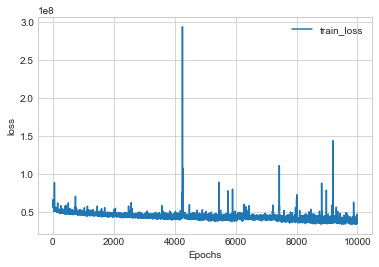

In [1978]:
plt.plot(losses[10:], label='train_loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [1950]:
combid = [list(x) for x in itertools.combinations(np.arange(t_test.shape[0]), 2)]
comb0 = [c[0] for c in combid]
comb1 = [c[1] for c in combid]

In [1951]:
y_test[comb1] - y_test[comb0]

tensor([[-1725.9850],
        [  558.5800],
        [ 8575.2451],
        ...,
        [13252.0000],
        [ 6716.2700],
        [-6535.7295]])

In [1952]:
[c[0] for c in combid]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [1969]:
import random


def torch_fix_seed(seed=0):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed()

In [1954]:
_t_id = np.where((t_test.cpu().detach().numpy() == 1).all(axis=1))[0]
_c_id = np.where((t_test.cpu().detach().numpy() == 0).all(axis=1))[0]
_t_id
p = len(_t_id)/ len(t_test)

mmd_rbf(X_test[_t_id], X_test[_c_id], p, sig=0.1)

tensor(0.0022)

In [1955]:
def mmd_lin(Xt, Xc, p):
    mean_treated = torch.mean(Xt)
    mean_control = torch.mean(Xc)
    
    mmd = torch.square(2.0*p*mean_treated - 2.0*(1.0-p)*mean_control).sum()

    return mmd

In [1956]:
mmd_lin(X_test[_t_id], X_test[_c_id], p)

tensor(2760302.)

In [1957]:
rep_test = model.repnet(X_test)

In [1958]:
mmd_lin(rep_test[_t_id], rep_test[_c_id], p)

tensor(791.8182, grad_fn=<SumBackward0>)

In [1959]:
mmd_rbf(rep_test[_t_id], rep_test[_c_id], p, sig=0.1)

tensor(0., grad_fn=<MulBackward0>)

In [1960]:
rep_test[_t_id].mean()

tensor(13.1248, grad_fn=<MeanBackward0>)

In [1961]:
rep_test[_c_id].mean()

tensor(20.5963, grad_fn=<MeanBackward0>)

In [1962]:
model.forward(X_test, t_test)

tensor([[6030.4541],
        [4243.4795],
        [5336.3350],
        [7270.6172],
        [4346.7896],
        [3694.9255],
        [7024.2817],
        [4891.2959],
        [5244.4463],
        [8358.6025],
        [6636.5547],
        [5906.2510],
        [7491.0078],
        [8627.6445],
        [9119.0713],
        [8403.8164],
        [8396.9316],
        [7433.7441],
        [5735.8164],
        [4735.6309],
        [1599.9331],
        [7547.6025],
        [8852.7461],
        [6367.6572],
        [6006.0420],
        [5526.7646],
        [5472.8701],
        [5670.0977],
        [4378.1675],
        [1487.6572],
        [6756.5103],
        [8589.4268],
        [8840.3369],
        [5705.0078],
        [5774.3682],
        [7223.0078],
        [4096.2061],
        [5646.7891],
        [7771.1328],
        [1788.2694],
        [9252.7656],
        [5233.8682],
        [1540.8793],
        [5644.9775],
        [7722.3994],
        [4829.9355],
        [6667.8818],
        [4882

In [1940]:
y_test

tensor([[ 1725.9850],
        [    0.0000],
        [ 2284.5649],
        [10301.2305],
        [    0.0000],
        [ 4666.2358],
        [    0.0000],
        [ 5752.7900],
        [ 6231.5732],
        [25564.6699],
        [ 7240.8599],
        [ 5748.3560],
        [24290.8691],
        [ 9853.4814],
        [ 3892.3320],
        [  803.8833],
        [18510.0000],
        [    0.0000],
        [  675.3210],
        [    0.0000],
        [12187.4102],
        [    0.0000],
        [ 7215.7388],
        [ 9206.2373],
        [25564.6699],
        [17627.8008],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [  366.4762],
        [17833.1992],
        [ 9922.9336],
        [ 8844.1943],
        [ 4814.6270],
        [ 3392.8601],
        [12718.7900],
        [ 9438.2402],
        [12104.0596],
        [12760.1699],
        [ 5661.1709],
        [    0.0000],
        [ 3023.8789],
        [ 8154.0952],
        [    0.0000],
        [2

In [1979]:
for (x, y, z) in dataloader:
                y = y.to(device=torch.device("cpu"))
                print(y)

tensor([[0.0000e+00],
        [0.0000e+00],
        [7.2850e+03],
        [2.9362e+03],
        [9.5985e+03],
        [0.0000e+00],
        [5.4957e+03],
        [0.0000e+00],
        [3.1966e+03],
        [2.6643e+03],
        [9.4737e+03],
        [8.5467e+03],
        [0.0000e+00],
        [6.0308e+04],
        [9.7372e+03],
        [0.0000e+00],
        [6.6941e+03],
        [1.0363e+04],
        [3.9027e+03],
        [2.2565e+03],
        [1.2738e+03],
        [7.6291e+02],
        [0.0000e+00],
        [1.8930e+03],
        [6.0838e+03],
        [0.0000e+00],
        [1.0747e+04],
        [9.4575e+01],
        [0.0000e+00],
        [9.7323e+03],
        [1.8133e+04],
        [7.6990e+03],
        [6.7177e+03],
        [6.7885e+03],
        [1.0804e+04],
        [1.6747e+04],
        [4.4828e+03],
        [1.7304e+03],
        [0.0000e+00],
        [1.7452e+03],
        [2.0984e+02],
        [1.7359e+04],
        [0.0000e+00],
        [2.3765e+04],
        [0.0000e+00],
        [3